# Lab 5: Spam Detection

**Deadline**: Monday, March 15, 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gautam Dawar <gautam.dawar@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1iQRhe-wCiY-DVWTZ0wlGFqD_q2RhjQ5x/view?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
# Spam SMS has the label "spam" and non-spam SMS has the label "ham".

print_spam = False
for line in open('SMSSpamCollection'):
    label, sms = line.split('\t')

    if label == 'ham' and not print_spam:
        print("Non-spam SMS label =", label)
        print("Non-spam SMS example =", sms)
        print_spam = True

    if label == 'spam' and print_spam:
        print("Spam SMS label =", label)
        print("Spam SMS example =", sms)
        break

Non-spam SMS label = ham
Non-spam SMS example = Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam SMS label = spam
Spam SMS example = Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [3]:
spam_count = 0
total_count = 0

for line in open('SMSSpamCollection'):
    spam_count += int(line[0] == 's')
    total_count += 1

print("Total spam messages =", spam_count)
print("Total non-spam messages =", (total_count - spam_count))

Total spam messages = 747
Total non-spam messages = 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [4]:
# Two advantages of character-level language models are that the vocabulary
# size for analysis is far smaller for characters than words, and can learn how
# to generate grammatically correct words and sequences such as grammtical
# anomalies and proper punctuation. This means that character-level LMs require
# less memory and can recognize grammatical errors.

# Two disadvantages are that character-level LMs require more tokens for each 
# datum and need deeper and larger hidden layers. This results in longer 
# training times and lower overall accuracy than word-level LMs. 

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [5]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                         tokenize=lambda x: x, # because are building a character-RNN
                                         include_lengths=True, # to track the length of sequences, for batching
                                         batch_first=True,
                                         use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                          use_vocab=False,     # don't need to track vocabulary
                                          is_target=True,      
                                          batch_first=True,
                                          preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                               "tsv",               # fields are separated by a tab
                                               fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

dataset_size = len(dataset)
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2],
                                   stratified=True)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [6]:
# Having a balanced training set is important since we want the number of spam
# and non-spam SMS to be similar. If we didn't copy all of the spam SMS, there
# would be way more non-spam than spam in the training set. This could result in
# the RNN model naively guessing all SMS to be non-spam, while still achieving 
# a high prediction accuracy. 

# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [7]:
# text_field.vocab.stoi is a dictionary that maps each character to a unique 
# index, which is simply one-hot encoding (string -> index)

# text_field.vocab.itos is a list that holds each character in their unique 
# index, mapping the one-hot encoding dictionary backwards (index -> string).

text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

print("text_field.vocab.stoi =", text_field.vocab.stoi)
print("text_field.vocab.itos =", text_field.vocab.itos)

text_field.vocab.stoi = defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f4ecfad4290>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, '7': 37, '4': 38, 'N': 39, 'x': 40, '6': 41, 'A': 42, '3': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'W': 49, 'U': 50, 'L': 51, 'H': 52, 'M': 53, 'D': 54, 'B': 55, 'F': 56, 'Y': 57, 'G': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'X': 67, 'V': 68, 'j': 69, '*': 70, 'K': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'q': 77, '"': 78, 'Q': 79, '#': 80, '@': 81, '=': 82, '>': 83, 'ü': 84, 'Z': 85, '<': 86, 'Ü': 87, '\x92': 88, '$': 89, '_': 90, '[': 91, ']': 92, '%': 93, '|': 94, '‘': 95, '\x93

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [8]:
# <unk> represents rare words that were not present in the vocabulary, stands
# for "unknown".

# <pad> represents empty padding within the dataset in order to make sure each 
# batch has the same size/length. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                                  batch_size=32,
                                                  sort_key=lambda x: len(x.sms), # to minimize padding
                                                  sort_within_batch=True,        # sort within each batch
                                                  repeat=False)                  # repeat the iterator for many epochs

In [10]:
for index, batch in enumerate(train_iter):
    if index == 10:
      break

    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

    print("Index =", index)
    print("Maximum input sequence length =", batch.sms[0].shape[1])
    print("Total number of <pad> tokens =", int((batch.sms[0] == text_field.vocab.stoi['<pad>']).sum()))
    print()

Index = 0
Maximum input sequence length = 128
Total number of <pad> tokens = 48

Index = 1
Maximum input sequence length = 143
Total number of <pad> tokens = 19

Index = 2
Maximum input sequence length = 140
Total number of <pad> tokens = 30

Index = 3
Maximum input sequence length = 137
Total number of <pad> tokens = 17

Index = 4
Maximum input sequence length = 72
Total number of <pad> tokens = 36

Index = 5
Maximum input sequence length = 89
Total number of <pad> tokens = 46

Index = 6
Maximum input sequence length = 125
Total number of <pad> tokens = 48

Index = 7
Maximum input sequence length = 70
Total number of <pad> tokens = 47

Index = 8
Maximum input sequence length = 160
Total number of <pad> tokens = 0

Index = 9
Maximum input sequence length = 48
Total number of <pad> tokens = 43



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [11]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [12]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamClassifier, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # look up the embedding
        x = self.emb[x]

        # set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [13]:
def get_accuracy(model, data, batch_size=64):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.legacy.data.BucketIterator(data,
                                                       batch_size=batch_size,
                                                       sort_key=lambda x: len(x.sms), # to minimize padding
                                                       sort_within_batch=True,        # sort within each batch
                                                       repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [14]:
import time
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, batch_size=64, num_epochs=20, learning_rate=5e-5, plot=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    # get DataLoaders
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                                        batch_size=batch_size,
                                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                                        sort_within_batch=True,        # sort within each batch
                                                        repeat=False)                  # repeat the iterator for many epochs
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                                        batch_size=batch_size,
                                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                                        sort_within_batch=True,        # sort within each batch
                                                        repeat=False)                  # repeat the iterator for many epochs

    # start timing
    start_time = time.time()
    for epoch in range(num_epochs):
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for message, labels in valid_loader:
            pred = model(message[0])
            loss = criterion(pred, labels)
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size=batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size=batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        
    if plot:
        # plotting
        plt.title("Training Curve")
        plt.plot(train_losses, label="Train")
        plt.plot(valid_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

        plt.title("Training Curve")
        plt.plot(epochs, train_acc, label="Train")
        plt.plot(epochs, valid_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch 1; Loss 0.719795; Train Acc 0.525452; Val Acc 0.140807
Epoch 2; Loss 0.698946; Train Acc 0.587465; Val Acc 0.270852
Epoch 3; Loss 0.698869; Train Acc 0.635550; Val Acc 0.658296
Epoch 4; Loss 0.663635; Train Acc 0.698060; Val Acc 0.751570
Epoch 5; Loss 0.592352; Train Acc 0.787597; Val Acc 0.852018
Epoch 6; Loss 0.459497; Train Acc 0.863041; Val Acc 0.820628
Epoch 7; Loss 0.594972; Train Acc 0.853921; Val Acc 0.783857
Epoch 8; Loss 0.185762; Train Acc 0.901011; Val Acc 0.915695
Epoch 9; Loss 0.434343; Train Acc 0.898856; Val Acc 0.862780
Epoch 10; Loss 0.060168; Train Acc 0.925883; Val Acc 0.939013
Epoch 11; Loss 0.385771; Train Acc 0.921406; Val Acc 0.895067
Epoch 12; Loss 0.220300; Train Acc 0.921074; Val Acc 0.905830
Epoch 13; Loss 0.224052; Train Acc 0.929033; Val Acc 0.907623
Epoch 14; Loss 0.208391; Train Acc 0.938650; Val Acc 0.942601
Epoch 15; Loss 0.230327; Train Acc 0.940474; Val Acc 0.940807
Epoch 16; Loss 0.126281; Train Acc 0.944785; Val Acc 0.953363
Epoch 17; Loss 0.

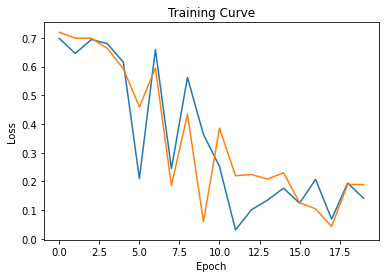

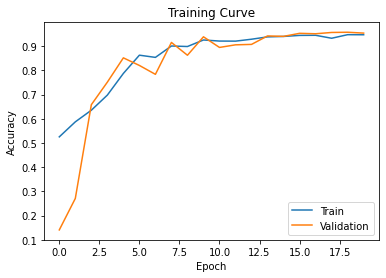

Final Training Accuracy: 0.9474382357817941
Final Validation Accuracy: 0.9542600896860987
Total time elapsed: 173.29 seconds


In [15]:
input_size = len(text_field.vocab.itos)

SLModel = SpamClassifier(input_size, 100, 2)
train_rnn_network(SLModel, train, valid, plot=True)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [16]:
# Double batch size and learning rate

# Doubling the batch size (and accomodating the larger batch size with a larger
# learning rate) is a first standard guess into the hyperparameter space search.

# Slightly worse training and validation accuracy and higher final losses
# Training was faster from default by around 13 seconds
SLModel = SpamClassifier(input_size, 100, 2)
train_rnn_network(SLModel, train, valid, batch_size=128, learning_rate=1e-04)

Epoch 1; Loss 0.687331; Train Acc 0.528436; Val Acc 0.809865
Epoch 2; Loss 0.684892; Train Acc 0.580667; Val Acc 0.853812
Epoch 3; Loss 0.662687; Train Acc 0.637539; Val Acc 0.834978
Epoch 4; Loss 0.679990; Train Acc 0.665561; Val Acc 0.782063
Epoch 5; Loss 0.638144; Train Acc 0.734704; Val Acc 0.834081
Epoch 6; Loss 0.698454; Train Acc 0.815951; Val Acc 0.819731
Epoch 7; Loss 0.444207; Train Acc 0.818438; Val Acc 0.767713
Epoch 8; Loss 0.254645; Train Acc 0.894876; Val Acc 0.893274
Epoch 9; Loss 0.436239; Train Acc 0.818438; Val Acc 0.848430
Epoch 10; Loss 0.237453; Train Acc 0.904825; Val Acc 0.884305
Epoch 11; Loss 0.106570; Train Acc 0.749959; Val Acc 0.914798
Epoch 12; Loss 0.223798; Train Acc 0.915603; Val Acc 0.924664
Epoch 13; Loss 0.740038; Train Acc 0.919748; Val Acc 0.927354
Epoch 14; Loss 0.485986; Train Acc 0.872492; Val Acc 0.946188
Epoch 15; Loss 0.158554; Train Acc 0.931023; Val Acc 0.954260
Epoch 16; Loss 0.162383; Train Acc 0.931355; Val Acc 0.954260
Epoch 17; Loss 0.

In [17]:
# Double hidden layer size

# Since adjusting the optimizer hyperparameters did not seem to provide 
# significant increase in accuracy, we can increase the depth of the network
# by doubling the number of hidden units to see if it would do the trick.

# Slightly worse training accuracy, but higher validation accuracy
# Lower final losses, overall slightly better performance
# Training was slower from default by around 110 seconds
SLModel = SpamClassifier(input_size, 200, 2)
train_rnn_network(SLModel, train, valid)

Epoch 1; Loss 0.708384; Train Acc 0.533908; Val Acc 0.159641
Epoch 2; Loss 0.681982; Train Acc 0.675676; Val Acc 0.748879
Epoch 3; Loss 0.371007; Train Acc 0.608025; Val Acc 0.887892
Epoch 4; Loss 0.433958; Train Acc 0.899685; Val Acc 0.932735
Epoch 5; Loss 0.154542; Train Acc 0.794893; Val Acc 0.925561
Epoch 6; Loss 0.429096; Train Acc 0.890565; Val Acc 0.886996
Epoch 7; Loss 0.243838; Train Acc 0.924391; Val Acc 0.949776
Epoch 8; Loss 0.086680; Train Acc 0.910794; Val Acc 0.954260
Epoch 9; Loss 0.501005; Train Acc 0.910463; Val Acc 0.958744
Epoch 10; Loss 0.125122; Train Acc 0.915934; Val Acc 0.932735
Epoch 11; Loss 0.380030; Train Acc 0.939148; Val Acc 0.961435
Epoch 12; Loss 0.101162; Train Acc 0.945449; Val Acc 0.954260
Epoch 13; Loss 0.156281; Train Acc 0.940640; Val Acc 0.960538
Epoch 14; Loss 0.119509; Train Acc 0.948433; Val Acc 0.961435
Epoch 15; Loss 0.149134; Train Acc 0.951583; Val Acc 0.964126
Epoch 16; Loss 0.092504; Train Acc 0.950754; Val Acc 0.964126
Epoch 17; Loss 0.

In [18]:
# Max-pooling over the entire output array

# Deepening the layer did not seem to improve the performance significantly,
# despite the cost of training time. Using max-pooling layers is another 
# hyperparameter related to the architecture, not the optimizer.

# Significantly higher training accuracy, and slightly higher validation
# accuracy, with lower losses
# Training was slower from default by around 65 seconds
class NewSpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NewSpamClassifier, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # look up the embedding
        x = self.emb[x]

        # set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

NSLModel = NewSpamClassifier(input_size, 100, 2)
train_rnn_network(SLModel, train, valid)

Epoch 1; Loss 0.020495; Train Acc 0.962361; Val Acc 0.975785
Epoch 2; Loss 0.312300; Train Acc 0.951086; Val Acc 0.909417
Epoch 3; Loss 0.093955; Train Acc 0.957387; Val Acc 0.940807
Epoch 4; Loss 0.073471; Train Acc 0.906152; Val Acc 0.973991
Epoch 5; Loss 0.256207; Train Acc 0.956060; Val Acc 0.947982
Epoch 6; Loss 0.355592; Train Acc 0.911955; Val Acc 0.912108
Epoch 7; Loss 0.117151; Train Acc 0.963853; Val Acc 0.964126
Epoch 8; Loss 0.070759; Train Acc 0.966175; Val Acc 0.974888
Epoch 9; Loss 0.256094; Train Acc 0.966175; Val Acc 0.978475
Epoch 10; Loss 0.702248; Train Acc 0.823412; Val Acc 0.798206
Epoch 11; Loss 0.260731; Train Acc 0.973470; Val Acc 0.970404
Epoch 12; Loss 0.140935; Train Acc 0.905820; Val Acc 0.935426
Epoch 13; Loss 0.152015; Train Acc 0.954071; Val Acc 0.934529
Epoch 14; Loss 0.127854; Train Acc 0.960040; Val Acc 0.956951
Epoch 15; Loss 0.103137; Train Acc 0.966009; Val Acc 0.956951
Epoch 16; Loss 0.089489; Train Acc 0.967667; Val Acc 0.956951
Epoch 17; Loss 0.

In [19]:
# Concatenation of different pooling methods over entire output array
# Uses both max-pooling and average-pooling

# Seeing that using a max-pooling layer improved our training and validation
# accuracy significantly, we can concatenate both max and average pooling 
# methods to improve it further. 

# Higher training and validation accuracy, higher final losses
# Training was faster from default by around 17 seconds
class BetterSpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BetterSpamClassifier, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # look up the embedding
        x = self.emb[x]

        # set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # forward propagate the RNN
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], 
                        torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

BSLModel = BetterSpamClassifier(input_size, 100, 2)
train_rnn_network(BSLModel, train, valid)

Epoch 1; Loss 0.679401; Train Acc 0.653291; Val Acc 0.486996
Epoch 2; Loss 0.701218; Train Acc 0.553474; Val Acc 0.235874
Epoch 3; Loss 0.717462; Train Acc 0.526115; Val Acc 0.147982
Epoch 4; Loss 0.718347; Train Acc 0.530095; Val Acc 0.156951
Epoch 5; Loss 0.711919; Train Acc 0.551318; Val Acc 0.194619
Epoch 6; Loss 0.663954; Train Acc 0.895540; Val Acc 0.851121
Epoch 7; Loss 0.555725; Train Acc 0.884430; Val Acc 0.895067
Epoch 8; Loss 0.302112; Train Acc 0.872161; Val Acc 0.946188
Epoch 9; Loss 0.474776; Train Acc 0.879125; Val Acc 0.951570
Epoch 10; Loss 0.185203; Train Acc 0.904825; Val Acc 0.954260
Epoch 11; Loss 0.498884; Train Acc 0.938484; Val Acc 0.934529
Epoch 12; Loss 0.273821; Train Acc 0.939811; Val Acc 0.937220
Epoch 13; Loss 0.414537; Train Acc 0.903167; Val Acc 0.857399
Epoch 14; Loss 0.214195; Train Acc 0.942961; Val Acc 0.932735
Epoch 15; Loss 0.251762; Train Acc 0.939977; Val Acc 0.926457
Epoch 16; Loss 0.149302; Train Acc 0.950423; Val Acc 0.955157
Epoch 17; Loss 0.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [20]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

print("False positive rate =", 1. - get_accuracy(BSLModel, valid_nospam))
print("False negative rate =", 1. - get_accuracy(BSLModel, valid_spam))

False positive rate = 0.041450777202072575
False negative rate = 0.053333333333333344


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [21]:
# False positive rate measures how many non-spam emails the model will mark as 
# spam. This is dangerous, as it will mean the detection algorithm could
# possibly mark important non-spam email, such as business or personal emails,
# into the spam bin.

# False negative rate measures how many spam emails the model will miss and mark
# as non-spam. This is less as important, as it will mean that the detection
# algorithm willy simply miss marking some emails as spam. 

# As the user will be the ultimate last-line of defense against spam mails, it 
# is far better to accidentally mark an email as non-spam than spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [22]:
print("Test accuracy =", get_accuracy(BSLModel, test))

Test accuracy = 0.9326750448833034


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [23]:
# Create a Dataset of only spam testing examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam testing examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

print("False positive rate =", 1. - get_accuracy(BSLModel, test_nospam))
print("False negative rate =", 1. - get_accuracy(BSLModel, test_spam))

False positive rate = 0.06735751295336789
False negative rate = 0.05369127516778527


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [24]:
msg = "machine learning is sooo cool!"

msg_stoi = torch.LongTensor([
    text_field.vocab.stoi[char]

    for char in msg
])

pred = BSLModel(msg_stoi.unsqueeze(0))
prob = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
print("Probability of spam =", prob)

Probability of spam = 0.09529487748984654


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [25]:
# Spam detection is a fairly straightforward task that is often used as an 
# introductory task for new students to machine learning. There is a variation
# of a spam-detecting algorithm in almost every machine learning field such as
# Naive-Bayes or SVM. 

# A super simple non-machine-learning spam detection algorithm can be a 
# heuristic filter with a list of common spam keywords. Given an email, the
# algorithm can search for certain keywords that are common in spam emails such
# as "payment" or "prize". The algorithm can then assign a value to this email
# (the higher the value, the more keywords are present, the more likely it will
# be a spam email), and if the value has surpassed a certain threshold, the
# algorithm will classify the email as spam.